In [1]:
import pandas as pd
from numpy import random

from consts import default_random_seed
from sample_generation import create_sample
from strata import Strata
from zhang_rubin_help_func import calc_non_parametric_zhang_rubin, calc_zhang_rubin_bounds_analytically, plot_zhang_rubin_bounds_on_survivors, \
    calc_zhang_rubin_bounds_using_cvar_est

random.seed(default_random_seed)

# $Y(t)|X,S_t=1$


In [2]:
# sample_for_y_dist = create_sample(
#     y0_dist_param ={'a0': 0.0, 'b0': 2.0, 'c0': 100.0, 'sigma_01': 1, 'sigma_00': 1} , 
#     y1_dist_param = {'a1': 0.0, 'b1': 4.0, 'c1': 100.0, 'sigma_11': 1, 'sigma_10': 1})

sample_for_y_dist = create_sample()
sample_for_y_dist_s = sample_for_y_dist.loc[sample_for_y_dist.D_obs==0] # survivers only


In [3]:
print("\nExample from each strata:")
display(sample_for_y_dist.groupby("stratum").sample(n=3, random_state=1))


Example from each strata:


,x,t,D0,D1,stratum,S1,S0,Y0,Y1,D_obs,...,mu0,mu1,sigma_0,sigma_1,a0,b0,c0,a1,b1,c1
7918,-0.772476,0,0,0,AS,1.0,1.0,10.023207,6.979855,0,...,8.455048,6.910096,1,1,0.0,2.0,10.0,0.0,4.0,10.0
4441,0.661246,0,0,0,AS,1.0,1.0,11.454635,14.160109,0,...,11.322491,12.644982,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7416,-0.390478,1,0,0,AS,1.0,1.0,10.409915,8.540856,0,...,9.219044,8.438087,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3417,0.308684,1,1,1,D,NaN,NaN,NaN,NaN,1,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9948,0.022873,0,1,1,D,NaN,NaN,NaN,NaN,1,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
5502,-0.534283,0,1,1,D,NaN,NaN,NaN,NaN,1,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
1133,-0.559634,1,0,1,H,NaN,0.0,-0.318115,NaN,1,...,-1.119267,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3691,0.049471,0,0,1,H,NaN,0.0,-0.175954,NaN,0,...,0.098943,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9260,-0.092492,0,0,1,H,NaN,0.0,0.499586,NaN,0,...,-0.184985,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7049,-0.025835,0,1,0,P,0.0,NaN,NaN,0.104010,1,...,NaN,-0.103340,1,1,0.0,2.0,10.0,0.0,4.0,10.0


## Using observational data:

1.   Zhang & Rubin
2.   Using the parametric assumptions - Y is normal, estimate mu out of two mixed gaussians that differ by one latent variable

### 1. Zhang & Rubin

#### Non parametric

In [4]:
zhang_rubin_lb, zhang_rubin_ub = calc_non_parametric_zhang_rubin(sample_for_y_dist)
print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb}, {zhang_rubin_ub}]")
as_df = sample_for_y_dist.loc[sample_for_y_dist.stratum==Strata.AS.name]
print(f"Actual AS treatment effect: {(as_df.Y1-as_df.Y0).mean()}")

Bounds by Zhang and Rubin: [-1.963831565780759, 0.2792491148288061]
Actual AS treatment effect: -0.09352604936304877


##### using CVaR

In [5]:
zhang_rubin_bounds_cvar = calc_zhang_rubin_bounds_using_cvar_est(sample_for_y_dist[['x','D_obs','Y_obs','t']])

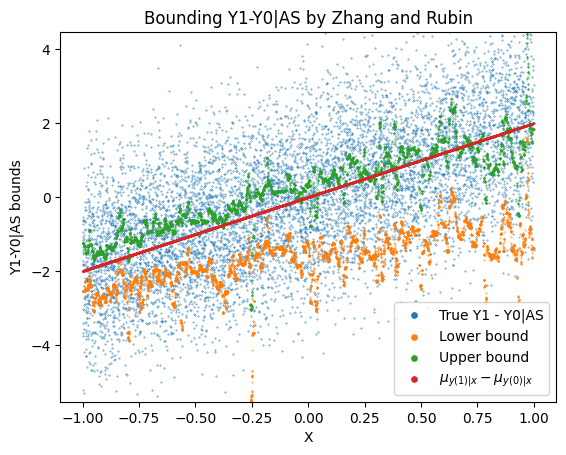

In [6]:
zr_bounds_cvar = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_cvar)

#### Parametric

Lower bound:
$min_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} - \bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=1,D=0}},1\right]} \right]$ <br>
Upper bound:
$max_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} - \bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=1,D=0}}\right]} \right]$

<br><br>


$\Rightarrow\bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
\int_{\Phi_{Y_{(1)}}^{-1}(0)}^{\Phi_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{P}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
  \int_{\Phi_{Y_{(1)}}^{-1}(0)}^{\Phi_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy$

<br>

$\Rightarrow\bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
\int_{\Phi_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)}^{\frac{\Phi_{Y_{(1)}}^{-1}(1)-\mu^P_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{P}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
  \int_{\Phi_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)}^{\frac{\Phi_{Y_{(1)}}^{-1}(1)-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=1,D=0}},1\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
\int_{\Phi_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=1,D=0}}\right)}^{\Phi_{Y_{(0)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{H}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
  \int_{\Phi_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=1,D=0}}\right)}^{\Phi_{Y_{(0)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=1,D=0}}}\cdot
\int_{\Phi_{Y_{(0)}}^{-1}\left(0\right)}^{\Phi_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{H}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=1,D=0}}}\cdot
  \int_{\Phi_{Y_{(0)}}^{-1}\left(0\right)}^{\Phi_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy$

Note that the weights are identifiable from observational data:
$\frac{\pi_{P}}{\pi_{P}+\pi_{AS}}=\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)$ <br>
$\frac{\pi_{H}}{\pi_{H}+\pi_{AS}}=\left(\frac{\pi_h}{P_{T=0,D=0}}\right)$

<br>
$\Phi_{Y_{(1)}}^{-1}(\alpha)=P(Y_{(1)}<F^{-1}(\alpha))$ where $F^{-1}(\alpha)$ is the $\alpha$ quantile of $Y_{(1)}$. Although quantile function for mixed Gaussians does not admit a closed-form expression, it can be calculated. First we'll calculate the quantile using binary search, and then we'll calculate the cdf of that quantile.

##### For 40 samples, plot $\pi_h$, parametric bounds for each $\pi_h$, final parametric and non parametric bounds

In [7]:
# pi_h_and_bounds_plots_controller(sample_for_y_dist)

TODO - Note that some pi's don't have the integral solution <br>
TODO - check the $\mu$ inside the integral vs outside, should be the same (for given bounds)<br>

In [8]:
zhang_rubin_bounds_analytic = calc_zhang_rubin_bounds_analytically(sample_for_y_dist_s)

row 0 out of 9238
row 1000 out of 9238
row 2000 out of 9238
row 3000 out of 9238
row 4000 out of 9238
row 5000 out of 9238
row 6000 out of 9238
row 7000 out of 9238
row 8000 out of 9238
row 9000 out of 9238


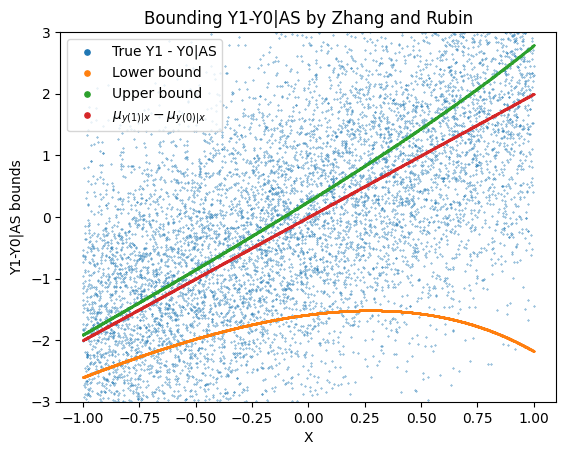

In [9]:
zr_bounds_analytic = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_analytic)